# Breast Cancer Classifier

### Using K Nearest Neighbor Classifier Algorithm

The following notebook is a sample project I created to build a K Nearest Neighbor Classifier.

The dataset for this project was made available by the breast cancer database of The University of Wisconsin Hospitals in Madison, WI. It was downloaded from Kaggle at https://www.kaggle.com/roustekbio/breast-cancer-csv.

The data set is relatively clean. According to the documentation provided at Kaggle, there are 16 missing values in the data set. The missing data is denoted with a '?'. I'll run a few test, though, to confirm the data is formatted for use in the K Nearest Neighbor algorithm.

In [2]:
# most of the Libraries needed for project loaded here.

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

In [3]:
# I'll handle the missing values by changing '?' to 'NaN' on the data load.

missing_values = ['?']

table = pd.read_csv('breastCancer.csv', na_values = missing_values)

In [4]:
table.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [5]:
table.shape

(699, 11)

In [6]:
table.columns

Index(['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity',
       'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'],
      dtype='object')

In [7]:
table['class'].value_counts()

2    458
4    241
Name: class, dtype: int64

According to notes that accompany database, '2' is the 'benign' label and '4' is the 'malignant' label in the 'class' column.

In [8]:
# check location of NaN values

table.isnull().sum()

id                    0
clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nucleoli        16
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64

The null values are all in the Bare Nucleoli column. Range of scores in the column is 1-10. Using the median for the missing values will lead to a more accurate classification than assigning 0 for the missing data since all the other lines in the table have a score of 1-10 for this feature.

In [9]:
# Fill NaN values with column mean. Check to confirm table has been updated.

table = table.fillna(table.median()['bare_nucleoli'])

table.isnull().sum()

id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64

In [10]:
table.dtypes

id                     int64
clump_thickness        int64
size_uniformity        int64
shape_uniformity       int64
marginal_adhesion      int64
epithelial_size        int64
bare_nucleoli        float64
bland_chromatin        int64
normal_nucleoli        int64
mitoses                int64
class                  int64
dtype: object

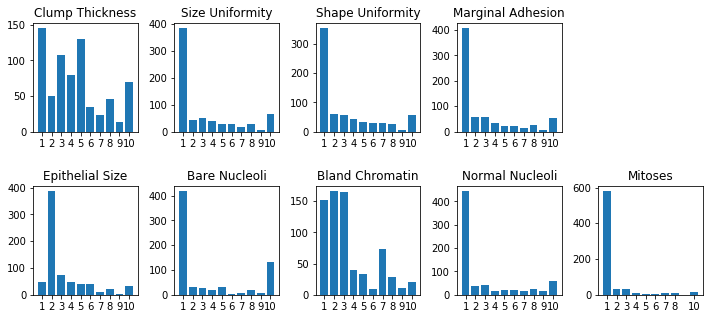

In [11]:
# Show plot of the nine factors determining if clump is benign or magligant to get a sense of score distributions.

fig = plt.figure(figsize = (12, 5))

plt.subplot(2, 5, 1)
labels1, counts1 = np.unique(table.clump_thickness, return_counts=True)
plt.bar(labels1, counts1, align = 'center')
plt.gca().set_xticks(labels1)
plt.title('Clump Thickness')

plt.subplot(2, 5, 2)
labels2, counts2 = np.unique(table.size_uniformity, return_counts=True)
plt.bar(labels2, counts2, align = 'center')
plt.gca().set_xticks(labels2)
plt.title('Size Uniformity')

plt.subplot(2, 5, 3)
labels3, counts3 = np.unique(table.shape_uniformity, return_counts=True)
plt.bar(labels3, counts3, align = 'center')
plt.gca().set_xticks(labels3)
plt.title('Shape Uniformity')

plt.subplot(2, 5, 4)
labels4, counts4 = np.unique(table.marginal_adhesion, return_counts=True)
plt.bar(labels4, counts4, align = 'center')
plt.gca().set_xticks(labels4)
plt.title('Marginal Adhesion')

plt.subplot(2, 5, 6)
labels5, counts5 = np.unique(table.epithelial_size, return_counts=True)
plt.bar(labels5, counts5, align = 'center')
plt.gca().set_xticks(labels5)
plt.title('Epithelial Size')

plt.subplot(2, 5, 7)
labels6, counts6 = np.unique(table.bare_nucleoli, return_counts=True)
plt.bar(labels6, counts6, align = 'center')
plt.gca().set_xticks(labels6)
plt.title('Bare Nucleoli')

plt.subplot(2, 5, 8)
labels7, counts7 = np.unique(table.bland_chromatin, return_counts=True)
plt.bar(labels7, counts7, align = 'center')
plt.gca().set_xticks(labels7)
plt.title('Bland Chromatin')

plt.subplot(2, 5, 9)
labels8, counts8 = np.unique(table.normal_nucleoli, return_counts=True)
plt.bar(labels8, counts8, align = 'center')
plt.gca().set_xticks(labels8)
plt.title('Normal Nucleoli')

plt.subplot(2, 5, 10)
labels9, counts9 = np.unique(table.mitoses, return_counts=True)
plt.bar(labels9, counts9, align = 'center')
plt.gca().set_xticks(labels9)
plt.title('Mitoses')

plt.subplots_adjust(hspace = .5, wspace = .35)
plt.show()
fig.savefig('feature_bars.png')

Looks like Clump Thickness and Bland Chromatin have the most score distribution. We'll run a correlation matrix to figure out to what degree our features are correlated.

In [12]:
# create table of features and outcome (without the patient id's) for our correlation plot

features = table[['clump_thickness', 'size_uniformity', 'shape_uniformity',
       'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']]

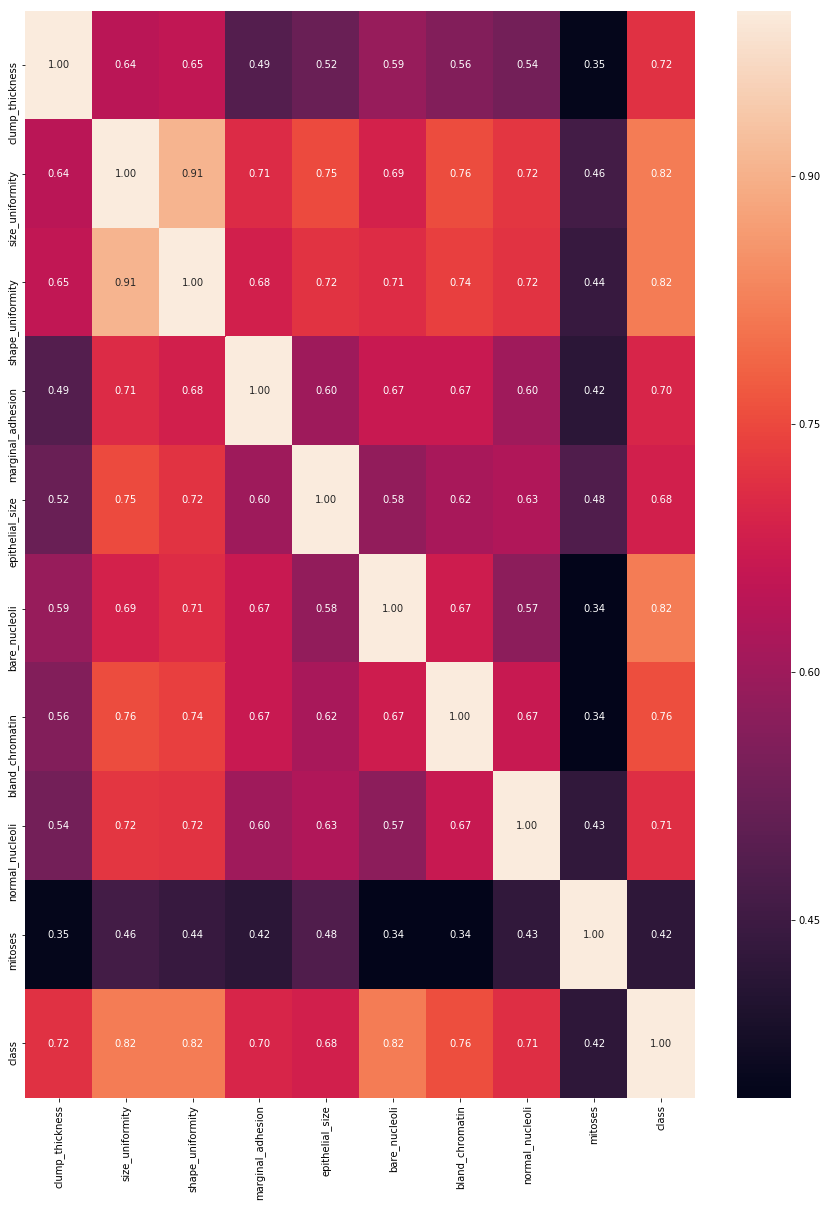

In [14]:
import seaborn as sns
from pylab import rcParams

# plot correlation's matrix to explore dependency between features

def plot_correlation(data):

    # init figure size
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('b_cancer_corr.png')

# plot correlation & densities
plot_correlation(features)

Looks like Size Uniformity and Shape Uniformity are the highest correlated features. All of our features look significantly correlated with our outcome, so perhaps they should all be included in our model. Let's look at the density plots for each of features relative to the outcome to see if any features could be dropped.

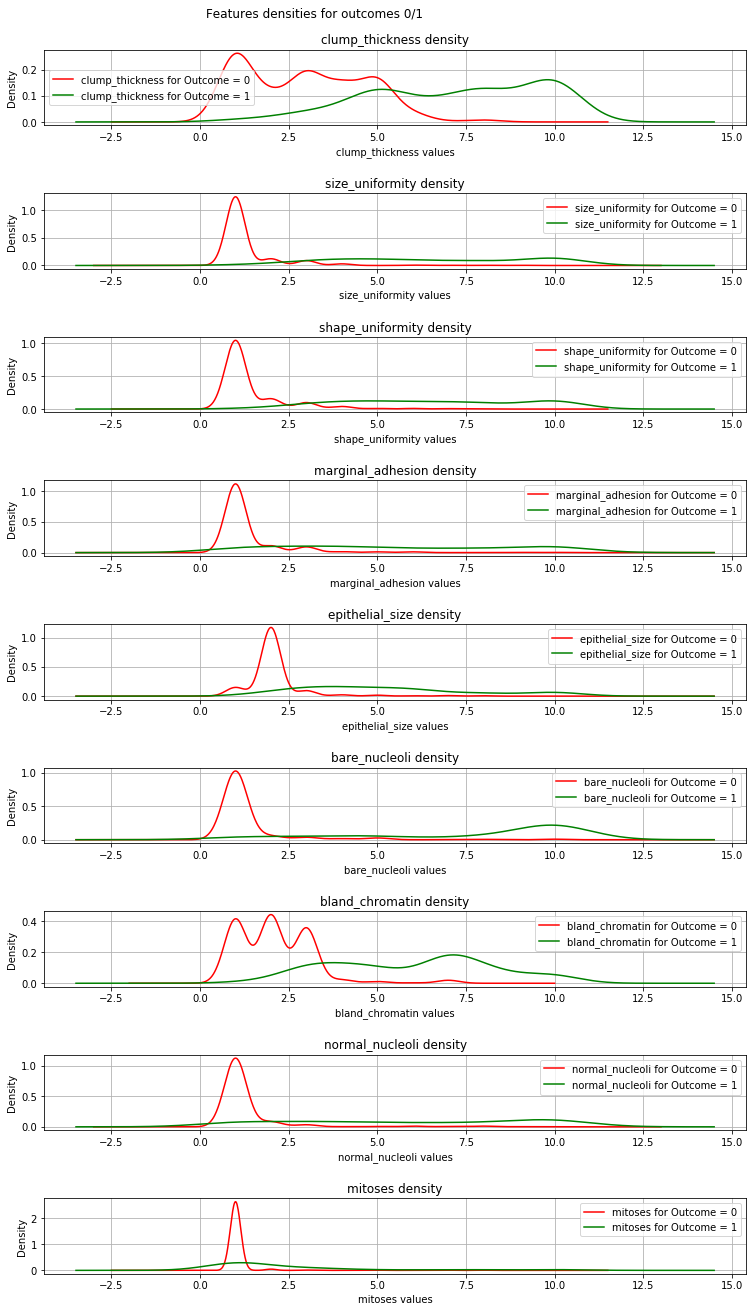

In [16]:
names = list(features.columns)

# plot features densities depending on the outcome values

def plot_densities(data):
    
    # set up fig size to fit all subplots 
    rcParams['figure.figsize'] = 15, 20

    # separate data based on outcome values 
    outcome_0 = data[data['class'] == 2]
    outcome_1 = data[data['class'] == 4]

    # init figure
    fig, axs = plt.subplots(9, 1)
    fig.suptitle('Features densities for outcomes 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    
    # plot densities for outcomes
    for column_name in names[:-1]: 
        ax = axs[names.index(column_name)]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Outcome = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="green", legend=True,
                                     label=column_name + ' for Outcome = 1')
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.show()
    fig.savefig('densities.png')

# plot correlation & densities
plot_densities(features)

All of the density curves above show significant difference between the two outcomes, so it turns out each feature is relevant to separating our two outcomes. Leaving out any of the features would weaken the accuracy of our model, so we will include them all.

## The Classifier

Now we're ready to set up our classifier.

In [17]:
# create our feature data set.

X = table[['clump_thickness', 'size_uniformity', 'shape_uniformity',
       'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
       'bland_chromatin', 'normal_nucleoli', 'mitoses']].values
X[0:5]

array([[ 5.,  1.,  1.,  1.,  2.,  1.,  3.,  1.,  1.],
       [ 5.,  4.,  4.,  5.,  7., 10.,  3.,  2.,  1.],
       [ 3.,  1.,  1.,  1.,  2.,  2.,  3.,  1.,  1.],
       [ 6.,  8.,  8.,  1.,  3.,  4.,  3.,  7.,  1.],
       [ 4.,  1.,  1.,  3.,  2.,  1.,  3.,  1.,  1.]])

In [18]:
# create list of lables.

y = table['class'].values
y[0:5]

array([2, 2, 2, 2, 2], dtype=int64)

In [19]:
# normalize the dataset

X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.20693572, -0.69999505, -0.74329904, -0.63324716, -0.54956136,
        -0.68697917, -0.17966213, -0.61182504, -0.34391178],
       [ 0.20693572,  0.28384518,  0.2668747 ,  0.76862067,  1.71010564,
         1.79966407, -0.17966213, -0.28411186, -0.34391178],
       [-0.50386559, -0.69999505, -0.74329904, -0.63324716, -0.54956136,
        -0.41068547, -0.17966213, -0.61182504, -0.34391178],
       [ 0.56233637,  1.59563215,  1.61377302, -0.63324716, -0.09762796,
         0.14190191, -0.17966213,  1.35445405, -0.34391178],
       [-0.14846494, -0.69999505, -0.74329904,  0.06768675, -0.54956136,
        -0.68697917, -0.17966213, -0.61182504, -0.34391178]])

In [20]:
# create the training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (559, 9) (559,)
Test set: (140, 9) (140,)


In [21]:
# import algorithms

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [22]:
# set up a for loop to test a range of K's to find the most accurate one

Ks = 10
mean_acc_train = np.zeros((Ks-1))
mean_acc_test = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1, Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    mean_acc_train[n-1] = metrics.accuracy_score(y_train, neigh.predict(X_train))
    yhat=neigh.predict(X_test)
    mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1] = np.std(yhat == y_test)/np.sqrt(yhat.shape[0])

print("Train set accuracy: ", mean_acc_train)
print("Test set accuracy: ", mean_acc_test)

Train set accuracy:  [1.         0.96958855 0.97853309 0.97495528 0.96958855 0.96958855
 0.96779964 0.96779964 0.96958855]
Test set accuracy:  [0.94285714 0.93571429 0.96428571 0.96428571 0.96428571 0.96428571
 0.97142857 0.96428571 0.97142857]


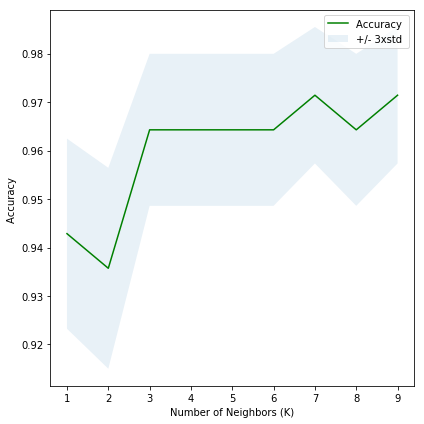

In [23]:
# plot the resulting accuracies for K

fig = plt.figure(figsize = (6, 6))
plt.plot(range(1, Ks), mean_acc_test,'g')
plt.fill_between(range(1, Ks), mean_acc_test - 1 * std_acc, mean_acc_test + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
fig.savefig('accuracy.png')

In [24]:
print("The best accuracy was with", mean_acc_test.max(), "with k =", mean_acc_test.argmax()+1)

The best accuracy was with 0.9714285714285714 with k = 7
